In [1]:
%matplotlib inline
import utils3
from utils3 import *

Using Theano backend.
/home/karel/anaconda3/lib/python3.6/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Graphics Device (0000:02:00.0)


In [2]:
#path = "data/ml-20m/"
path = "data/ml-small/"
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)
batch_size=64

## Set up data

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
len(ratings)

100004

Just for display purposes, let's read in the movie names too.

In [5]:
movie_names = pd.read_csv(path+'movies.csv').set_index('movieId')['title'].to_dict()

In [6]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

In [7]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

We update the movie and user ids so that they are contiguous integers, which we want when using embeddings.

In [8]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

In [9]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), 
    ratings.userId.max(), ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [10]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

This is the number of latent factors in each embedding.

In [11]:
n_factors = 50

In [12]:
np.random.seed = 42

Randomly split into training and validation.

In [13]:
msk = np.random.rand(len(ratings)) < 0.8
trn = ratings[msk]
val = ratings[~msk]

## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [35]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:20]

In [36]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:20]

In [37]:
top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')

In [38]:
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

In [119]:
pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,27,49,57,69,72,79,88,89,92,99,106,121,143,179,180,197,402,417,432,505
userId,,,,,,,,,,,,,,,,,,,,
14,3.0,5.0,1.0,5.0,3.0,4.0,0.5,4.0,5.0,2.0,5.0,4.0,5.0,5.0,4.0,5.0,5.0,2.0,2.5,5.0
22,3.5,4.5,4.5,3.5,3.5,3.5,4.0,3.5,4.5,5.0,4.0,3.5,4.5,4.5,4.5,4.5,4.0,3.0,3.5,4.5
29,5.0,5.0,5.0,5.0,4.0,5.0,5.0,4.0,4.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,3.0,4.0,4.0,5.0
72,4.0,5.0,5.0,4.0,4.0,5.0,5.0,3.0,4.5,5.0,5.0,4.5,4.5,5.0,5.0,5.0,4.5,5.0,3.5,4.0
211,5.0,4.0,4.0,3.0,3.0,5.0,3.0,3.0,4.0,4.5,NaN,4.0,4.0,NaN,3.0,3.0,5.0,3.0,3.0,NaN
212,2.5,NaN,2.0,4.0,5.0,NaN,3.0,4.0,2.5,NaN,5.0,NaN,5.0,5.0,3.0,3.0,4.0,3.0,5.0,2.0
293,3.0,NaN,4.0,3.5,4.0,4.0,5.0,3.0,NaN,3.0,4.0,NaN,4.0,4.0,4.5,4.0,4.5,4.0,4.5,NaN
310,3.0,3.0,5.0,4.5,4.5,5.0,3.0,4.5,2.0,4.5,3.5,NaN,4.0,3.0,4.5,4.5,4.0,3.0,4.5,4.0
379,5.0,5.0,5.0,NaN,4.0,NaN,4.0,4.0,5.0,4.0,4.0,5.0,4.0,4.0,NaN,3.0,5.0,4.0,4.0,4.0


## Dot product

The most basic model is a dot product of a movie embedding and a user embedding. Let's see how well that works:

In [14]:
user_in = Input(shape=(1,), dtype='int64', name='user_in')
u = Embedding(n_users, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(user_in)
movie_in = Input(shape=(1,), dtype='int64', name='movie_in')
m = Embedding(n_movies, n_factors, input_length=1, embeddings_regularizer=l2(1e-4))(movie_in)

In [15]:
x = merge([u, m], mode='dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

/home/karel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/home/karel/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [16]:

model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/1
80151/80151 [==============================] - 2s - loss: 9.9570 - val_loss: 4.3077


In [17]:
model.optimizer.lr=0.01

In [18]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=3, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/3
80151/80151 [==============================] - 1s - loss: 3.1407 - val_loss: 2.8060
Epoch 2/3
80151/80151 [==============================] - 1s - loss: 2.4053 - val_loss: 2.5939
Epoch 3/3
80151/80151 [==============================] - 1s - loss: 2.2334 - val_loss: 2.5499


In [19]:
model.optimizer.lr=0.001

In [20]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/6
80151/80151 [==============================] - 1s - loss: 2.1683 - val_loss: 2.5380
Epoch 2/6
80151/80151 [==============================] - 1s - loss: 2.1326 - val_loss: 2.5396
Epoch 3/6
80151/80151 [==============================] - 1s - loss: 2.1078 - val_loss: 2.5447
Epoch 4/6
80151/80151 [==============================] - 1s - loss: 2.0879 - val_loss: 2.5420
Epoch 5/6
80151/80151 [==============================] - 1s - loss: 2.0690 - val_loss: 2.5513
Epoch 6/6
80151/80151 [==============================] - 1s - loss: 2.0498 - val_loss: 2.5598


The [best benchmarks](http://www.librec.net/example.html) are a bit over 0.9, so this model doesn't seem to be working that well...

##  Bias

The problem is likely to be that we don't have bias terms - that is, a single bias for each user and each movie representing how positive or negative each user is, and how good each movie is. We can add that easily by simply creating an embedding with one output for each movie and each user, and adding it to our output.

In [21]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [22]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [23]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length=1)(inp)
    return Flatten()(x)

In [87]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

AttributeError: module 'keras.layers' has no attribute 'sum'

In [94]:
#x = keras.layers.dot([u,m],axes=1)
x = merge([u, m], mode='dot')
x = Flatten()(x)
x = merge([x, ub], mode='sum')
x = merge([x, mb], mode='sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(0.001), loss='mse')

/home/karel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  
/home/karel/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/karel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  after removing the cwd from sys.path.
/home/karel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [89]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=1, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/1
80151/80151 [==============================] - 2s - loss: 9.1427 - val_loss: 3.8520


In [27]:
model.optimizer.lr=0.01

In [28]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=6, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/6
80151/80151 [==============================] - 2s - loss: 2.5889 - val_loss: 2.3191
Epoch 2/6
80151/80151 [==============================] - 2s - loss: 2.0127 - val_loss: 2.1242
Epoch 3/6
80151/80151 [==============================] - 2s - loss: 1.8591 - val_loss: 2.0234
Epoch 4/6
80151/80151 [==============================] - 2s - loss: 1.7653 - val_loss: 1.9487
Epoch 5/6
80151/80151 [==============================] - 2s - loss: 1.6849 - val_loss: 1.8686
Epoch 6/6
80151/80151 [==============================] - 2s - loss: 1.6066 - val_loss: 1.8069


In [29]:
model.optimizer.lr=0.001

In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/10
80151/80151 [==============================] - 2s - loss: 1.5306 - val_loss: 1.7436
Epoch 2/10
80151/80151 [==============================] - 2s - loss: 1.4585 - val_loss: 1.6756
Epoch 3/10
80151/80151 [==============================] - 2s - loss: 1.3877 - val_loss: 1.6202
Epoch 4/10
80151/80151 [==============================] - 2s - loss: 1.3198 - val_loss: 1.5638
Epoch 5/10
80151/80151 [==============================] - 2s - loss: 1.2540 - val_loss: 1.5100
Epoch 6/10
80151/80151 [==============================] - 2s - loss: 1.1922 - val_loss: 1.4579
Epoch 7/10
80151/80151 [==============================] - 2s - loss: 1.1333 - val_loss: 1.4138
Epoch 8/10
80151/80151 [==============================] - 2s - loss: 1.0762 - val_loss: 1.3747
Epoch 9/10
80151/80151 [==============================] - 2s - loss: 1.0243 - val_loss: 1.3336
Epoch 10/10
80151/80151 [==============================] - 2s - loss: 0.9741 - val_loss: 1.2971

In [36]:
model.optimizer.lr=0.0001
model.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=5, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/5
80151/80151 [==============================] - 2s - loss: 0.5352 - val_loss: 1.0270
Epoch 2/5
80151/80151 [==============================] - 2s - loss: 0.5337 - val_loss: 1.0280
Epoch 3/5
80151/80151 [==============================] - 2s - loss: 0.5327 - val_loss: 1.0283
Epoch 4/5
80151/80151 [==============================] - 2s - loss: 0.5314 - val_loss: 1.0292
Epoch 5/5
80151/80151 [==============================] - 2s - loss: 0.5306 - val_loss: 1.0300


This result is quite a bit better than the best benchmarks that we could find with a quick google search - so looks like a great approach!

In [37]:
model.save_weights(model_path+'bias.h5')

In [38]:
model.load_weights(model_path+'bias.h5')

We can use the model to generate predictions by passing a pair of ints - a user id and a movie id. For instance, this predicts that user #3 would really enjoy movie #6.

In [39]:
model.predict([np.array([3]), np.array([6])])

array([[ 4.8826]], dtype=float32)

## Analyze results

To make the analysis of the factors more interesting, we'll restrict it to the top 2000 most popular movies.

In [40]:
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:2000]
topMovies = np.array(topMovies.index)

First, we'll look at the movie bias term. We create a 'model' - which in keras is simply a way of associating one or more inputs with one more more outputs, using the functional API. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [41]:
get_movie_bias = Model(movie_in, mb)
movie_bias = get_movie_bias.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [42]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-1.1550405, 'Battlefield Earth (2000)'),
 (-0.75790542, 'Anaconda (1997)'),
 (-0.75535893, 'Jaws 3-D (1983)'),
 (-0.75181359, 'Super Mario Bros. (1993)'),
 (-0.67879432, 'Speed 2: Cruise Control (1997)'),
 (-0.66687667, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.64726079, 'Blade: Trinity (2004)'),
 (-0.63065523, 'Police Academy 6: City Under Siege (1989)'),
 (-0.58898491, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.55840474, '2 Fast 2 Furious (Fast and the Furious 2, The) (2003)'),
 (-0.54347724, 'Howard the Duck (1986)'),
 (-0.50879806, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.50778717, 'Police Academy 3: Back in Training (1986)'),
 (-0.48135275, 'Spice World (1997)'),
 (-0.45842293, 'Avengers, The (1998)')]

In [43]:
sorted(movie_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.8479358, 'Tom Jones (1963)'),
 (1.8209023, 'Cinema Paradiso (Nuovo cinema Paradiso) (1989)'),
 (1.8173544, 'Band of Brothers (2001)'),
 (1.8163081, 'Shawshank Redemption, The (1994)'),
 (1.8054329, 'African Queen, The (1951)'),
 (1.8042767, 'Midnight in Paris (2011)'),
 (1.7968636, 'Treasure of the Sierra Madre, The (1948)'),
 (1.7939831, 'Raging Bull (1980)'),
 (1.7808105, 'It Happened One Night (1934)'),
 (1.7792168, 'Ran (1985)'),
 (1.7638524, 'Shadowlands (1993)'),
 (1.7613804, 'Lifeboat (1944)'),
 (1.7563008, 'About Time (2013)'),
 (1.754107, 'When We Were Kings (1996)'),
 (1.7394357, 'Modern Times (1936)')]

We can now do the same thing for the embeddings.

In [44]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(2000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [46]:
fac0 = movie_pca[0]

In [47]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'critically acclaimed' or 'classic'.

In [48]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.12125975305290004, 'Independence Day (a.k.a. ID4) (1996)'),
 (0.1045719103914792, 'Armageddon (1998)'),
 (0.074960192808366286, 'Twister (1996)'),
 (0.073455142883208563, 'Pearl Harbor (2001)'),
 (0.071090404781506009, 'Con Air (1997)'),
 (0.06483078449814686, 'Titanic (1997)'),
 (0.063798957800609402, 'Star Trek: First Contact (1996)'),
 (0.061372875191478195, 'Rock, The (1996)'),
 (0.060593700393838677, 'Stargate (1994)'),
 (0.060586123000246538, 'Waterworld (1995)')]

In [49]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.098936420904429889, 'Fargo (1996)'),
 (-0.096851357761291723, 'Pulp Fiction (1994)'),
 (-0.087650326309201054, 'Apocalypse Now (1979)'),
 (-0.078819178198182294, 'Taxi Driver (1976)'),
 (-0.077868641691344817, '2001: A Space Odyssey (1968)'),
 (-0.077820108432495691,
  "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (-0.076728748299739719, 'Clockwork Orange, A (1971)'),
 (-0.074547109334331077, 'Willy Wonka & the Chocolate Factory (1971)'),
 (-0.07379978740262412, 'Seven (a.k.a. Se7en) (1995)'),
 (-0.073367121742733701, 'Big Lebowski, The (1998)')]

In [50]:
fac1 = movie_pca[1]

In [51]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac1, topMovies)]

The 2nd is 'hollywood blockbuster'.

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.061082029679676679, 'Room with a View, A (1986)'),
 (0.057337463764076974, 'Truth About Cats & Dogs, The (1996)'),
 (0.056208583861747131, 'Charlie and the Chocolate Factory (2005)'),
 (0.056108580628010545, 'Alien: Resurrection (1997)'),
 (0.048609208733978324, 'Cars (2006)'),
 (0.044338850664015904,
  'League of Extraordinary Gentlemen, The (a.k.a. LXG) (2003)'),
 (0.04417950593892548, 'Beverly Hills Cop III (1994)'),
 (0.043824316162501306, 'Leaving Las Vegas (1995)'),
 (0.042688082533826111, 'Showgirls (1995)'),
 (0.041980651409766589, 'Bend It Like Beckham (2002)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.18456948619807909,
  'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.17099862162799004, 'Lord of the Rings: The Two Towers, The (2002)'),
 (-0.14834337746797663, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.14802479427086071,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.14300009517005471, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.13618788291585271, 'Matrix, The (1999)'),
 (-0.12533769647957538, 'Jurassic Park (1993)'),
 (-0.12102383851234931,
  'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.11216020601644694, 'Dark Knight, The (2008)'),
 (-0.11105621739146265, 'Saving Private Ryan (1998)')]

In [54]:
fac2 = movie_pca[2]

In [55]:
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(fac2, topMovies)]

The 3rd is 'violent vs happy'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.090865679462855009, 'Fight Club (1999)'),
 (0.081537356996925034, 'Dumb & Dumber (Dumb and Dumber) (1994)'),
 (0.079656748242321246, 'Royal Tenenbaums, The (2001)'),
 (0.0759551321231553, 'Clockwork Orange, A (1971)'),
 (0.074258254915148772, 'Office Space (1999)'),
 (0.073510892872797176, 'Scary Movie (2000)'),
 (0.073264050851240214,
  'Léon: The Professional (a.k.a. The Professional) (Léon) (1994)'),
 (0.072770257261700069, 'Stargate (1994)'),
 (0.070856068183543952, 'Eyes Wide Shut (1999)'),
 (0.070166951923358187, 'Seven (a.k.a. Se7en) (1995)')]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.11304680591225004, 'Beauty and the Beast (1991)'),
 (-0.11188556304168956, 'Finding Nemo (2003)'),
 (-0.10714782467022005,
  'Lord of the Rings: The Return of the King, The (2003)'),
 (-0.10058998997147339, 'Babe (1995)'),
 (-0.099463013587901508, 'Aladdin (1992)'),
 (-0.095624337455683578, 'Chicken Run (2000)'),
 (-0.085702734714850251, 'Toy Story 2 (1999)'),
 (-0.082504572501298848, 'Shrek (2001)'),
 (-0.081955469305752551, 'Toy Story (1995)'),
 (-0.081275667334143653, 'Sabrina (1995)')]

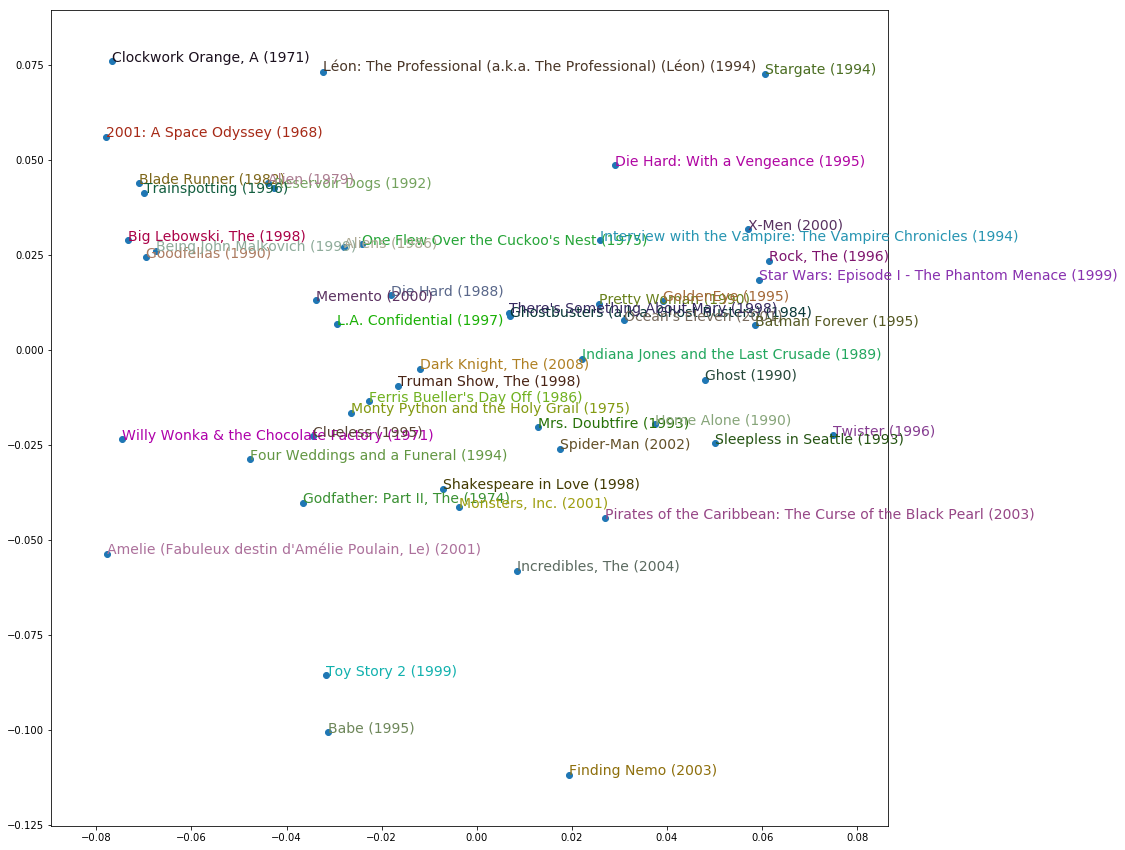

In [58]:
start=50; end=100
X = fac0[start:end]
Y = fac2[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[movies[i]], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

##  Neural net

Rather than creating a special purpose architecture (like our dot-product with bias earlier), it's often both easier and more accurate to use a standard neural network. Let's try it! Here, we simply concatenate the user and movie embeddings into a single vector, which we feed into the neural net.

In [59]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [79]:
x = merge([u, m], mode='concat')
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(80, activation='relu')(x)
x = Dropout(0.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(0.001), loss='mse')

/home/karel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  """Entry point for launching an IPython kernel.
/home/karel/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [61]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=8, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/8
80151/80151 [==============================] - 2s - loss: 2.4185 - val_loss: 0.9250
Epoch 2/8
80151/80151 [==============================] - 2s - loss: 1.4447 - val_loss: 0.8808
Epoch 3/8
80151/80151 [==============================] - 2s - loss: 1.2212 - val_loss: 0.8739
Epoch 4/8
80151/80151 [==============================] - 2s - loss: 1.0343 - val_loss: 0.8554
Epoch 5/8
80151/80151 [==============================] - 2s - loss: 0.9081 - val_loss: 0.8446
Epoch 6/8
80151/80151 [==============================] - 2s - loss: 0.8469 - val_loss: 0.8379
Epoch 7/8
80151/80151 [==============================] - 2s - loss: 0.8186 - val_loss: 0.8406
Epoch 8/8
80151/80151 [==============================] - 2s - loss: 0.8087 - val_loss: 0.8426


In [81]:
model.optimizer.lr=0.0001
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size=64, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80151 samples, validate on 19853 samples
Epoch 1/10
80151/80151 [==============================] - 2s - loss: 0.7943 - val_loss: 0.8394
Epoch 2/10
80151/80151 [==============================] - 2s - loss: 0.7929 - val_loss: 0.8439
Epoch 3/10
80151/80151 [==============================] - 2s - loss: 0.7892 - val_loss: 0.8426
Epoch 4/10
80151/80151 [==============================] - 2s - loss: 0.7946 - val_loss: 0.8409
Epoch 5/10
80151/80151 [==============================] - 2s - loss: 0.7909 - val_loss: 0.8401
Epoch 6/10
80151/80151 [==============================] - 2s - loss: 0.7907 - val_loss: 0.8359
Epoch 7/10
80151/80151 [==============================] - 2s - loss: 0.7888 - val_loss: 0.8395
Epoch 8/10
80151/80151 [==============================] - 2s - loss: 0.7898 - val_loss: 0.8378
Epoch 9/10
80151/80151 [==============================] - 2s - loss: 0.7873 - val_loss: 0.8406
Epoch 10/10
80151/80151 [==============================] - 2s - loss: 0.7853 - val_loss: 0.8406

This improves on our already impressive accuracy even further!